<div align=center>
		
<p></p>
<p></p>
<font size=5>
<font/>
<p></p>
 <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Department of Computer Engineering
</font>
<p></p>
<font color=blue>
Artificial Intelligence
</font>
<br/>
<br/>
Spring 2023

<div/>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 8 (Multi-Layer Perceptron)
			</font>
    <br/>
                <br/>
    </div>

# Multi-Layer Perceptron (MLP), MNIST
---

In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

This is a well-known and famous problem in the machine learning community! We try to train our network to recognize handwritten digits from 0 to 9. We use the famous MNIST dataset for this purpose. The dataset contains 60,000 training images and 10,000 testing images. Each image is a 28x28 grayscale image. We will use the MLP to classify the images.

Let's proceed with the exercise!

In [ ]:
# Run this code if you are trying to run the notebook locally
import torchvision.utils
!python3 -m venv ./venv
!source ./venv/bin/activate

In [1]:
%pip install torch numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [38]:
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

In this cell we first, download the dataset (using torch datasets) and then, create the test_set and train_sets to use in the rest of our notebook.
You can also change the `batch_size` in this cell to your desired amount.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# prepare data loaders
train_loader = data.DataLoader(train_data, batch_size, num_workers)
test_loader = data.DataLoader(test_data, batch_size, num_workers)

100%|██████████| 9912422/9912422 [00:17<00:00, 572263.97it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 614493.38it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:02<00:00, 557195.21it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 2314766.56it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



## See some of the training images

First thing to do in any machine learning task is to look at your data! load a batch of images from the training set and display them in a grid using the `imshow` function from `matplotlib.pyplot`. You can also use `torchvision.utils.make_grid` to create a grid from a list of images (batch).

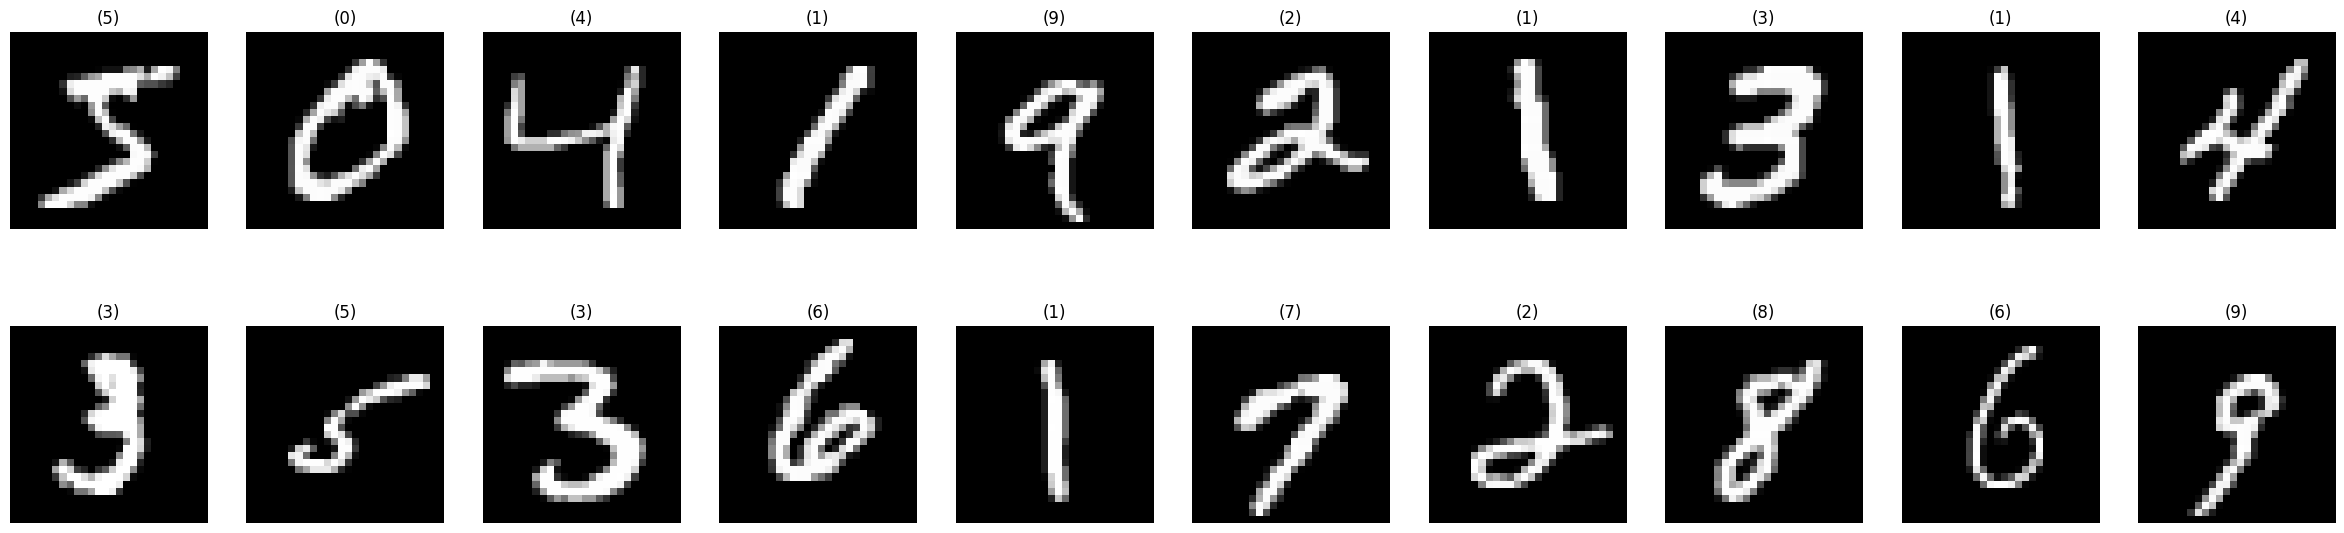

In [39]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
%matplotlib inline
# obtain one batch of training images
images, labels = iter(train_loader).__next__()
images = images.numpy()

#create a grid and show a batch of images in training data
fig = plt.figure(figsize=(30, 7))
for i in range(2):
    for j in range(10):
        index = 10 * i + j
        fig.add_subplot(2, 10, index + 1)
        label = str(labels[index])
        label = label.split("tensor")[1]
        image = images[index]
        plt.axis("off")
        plt.imshow(np.squeeze(image), cmap="gray")
        plt.title(label)
plt.show()

## View an Image in More Detail

Here, we look at one sample in a batch to see the pixel values (intensities). Note that our images are grayscale (even if the dataset were in RGB, the color data was irrelevant!) because for detecting the handwritten digits, the color of the ink of pen is not important (obviously)!

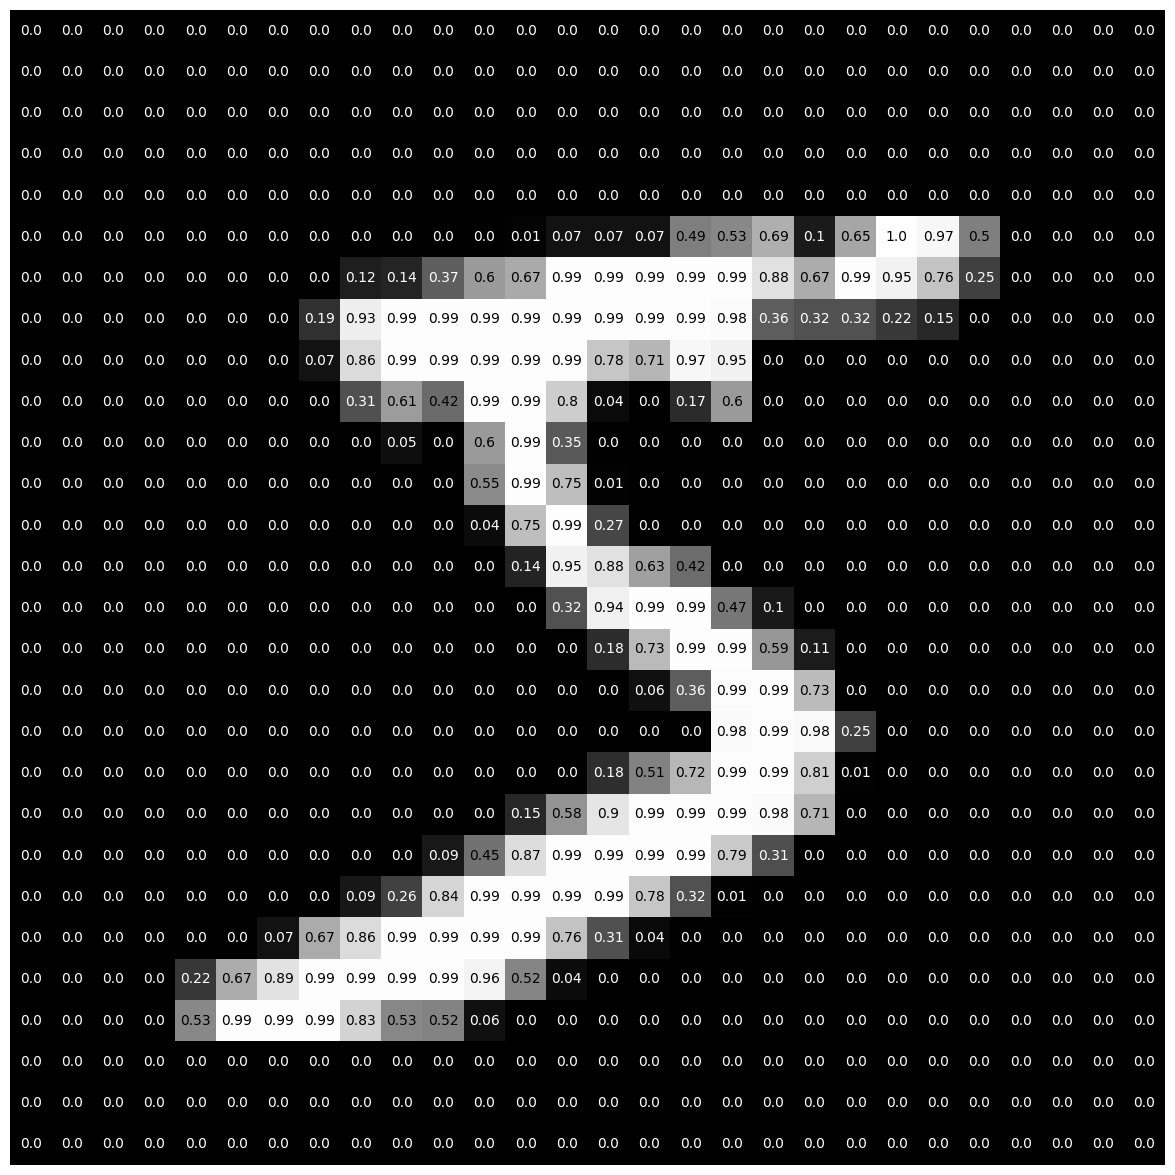

In [40]:
# You can round the pixel values with 2 floating point precision for better visualization!
img = np.squeeze(images[0])
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.axis("off")
width, height = img.shape
for x in range(width):
    for y in range(height):
        if img[x][y] != 0:
            val = round(img[x][y], 2)
        else:
            val = 0.0
        if img[x][y] < img.max() * 0.4:
            color = 'white'
        else:
            color = 'black'
        ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center',
                    color=color)

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

In this cell, you should define the network architecture. Note the dimensions of the input (print it out!) and the outputs. Your output should be a tensor of length 10 (digits 0 to 9) that indicates scores (probabilities) for an input image belonging to that class [$P(C_i|x)$]. Use `Drop out` layers to avoid overfitting!

In [41]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


##  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Here you should define the loss function used in training process and the optimizer. We recommend you use `cross-entropy` loss. But you can explore other loss functions if you think they work better in this case! Also, you can use `SGD` or `Adam` optimizer, or any other optimizers that you think would work better!

In [42]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Complete the code below:

In [44]:
# number of epochs to train the model
n_epochs = 40

valid_loss_min = np.Inf
for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    model.train()
    for data,label in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch + 1, train_loss))

Epoch: 1 	Training Loss: 0.186347
Epoch: 2 	Training Loss: 0.157637
Epoch: 3 	Training Loss: 0.136687
Epoch: 4 	Training Loss: 0.121958
Epoch: 5 	Training Loss: 0.109197
Epoch: 6 	Training Loss: 0.099769
Epoch: 7 	Training Loss: 0.089492
Epoch: 8 	Training Loss: 0.083102
Epoch: 9 	Training Loss: 0.076287
Epoch: 10 	Training Loss: 0.071608
Epoch: 11 	Training Loss: 0.065844
Epoch: 12 	Training Loss: 0.061459
Epoch: 13 	Training Loss: 0.057042
Epoch: 14 	Training Loss: 0.054568
Epoch: 15 	Training Loss: 0.049504
Epoch: 16 	Training Loss: 0.047188
Epoch: 17 	Training Loss: 0.044054
Epoch: 18 	Training Loss: 0.042137
Epoch: 19 	Training Loss: 0.039208
Epoch: 20 	Training Loss: 0.038028
Epoch: 21 	Training Loss: 0.035856
Epoch: 22 	Training Loss: 0.033595
Epoch: 23 	Training Loss: 0.032134
Epoch: 24 	Training Loss: 0.030725
Epoch: 25 	Training Loss: 0.029165
Epoch: 26 	Training Loss: 0.026315
Epoch: 27 	Training Loss: 0.025791
Epoch: 28 	Training Loss: 0.024583
Epoch: 29 	Training Loss: 0.0

---
## Test the Trained Network

And at last, you should test the model on test_set (previously unseen data). We will use test_set to evaluate the model's performance. Don't forget to prepare the model for evaluation(testing) using `model.eval()` in Pytorch!

You should report the Test Accuracy of your model.

In [45]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i),
                 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
              np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.055263

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1018/1032)
Test Accuracy of     3: 97% (986/1010)
Test Accuracy of     4: 98% (969/982)
Test Accuracy of     5: 98% (877/892)
Test Accuracy of     6: 98% (942/958)
Test Accuracy of     7: 97% (1006/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 97% (985/1009)

Test Accuracy (Overall): 98% (9829/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

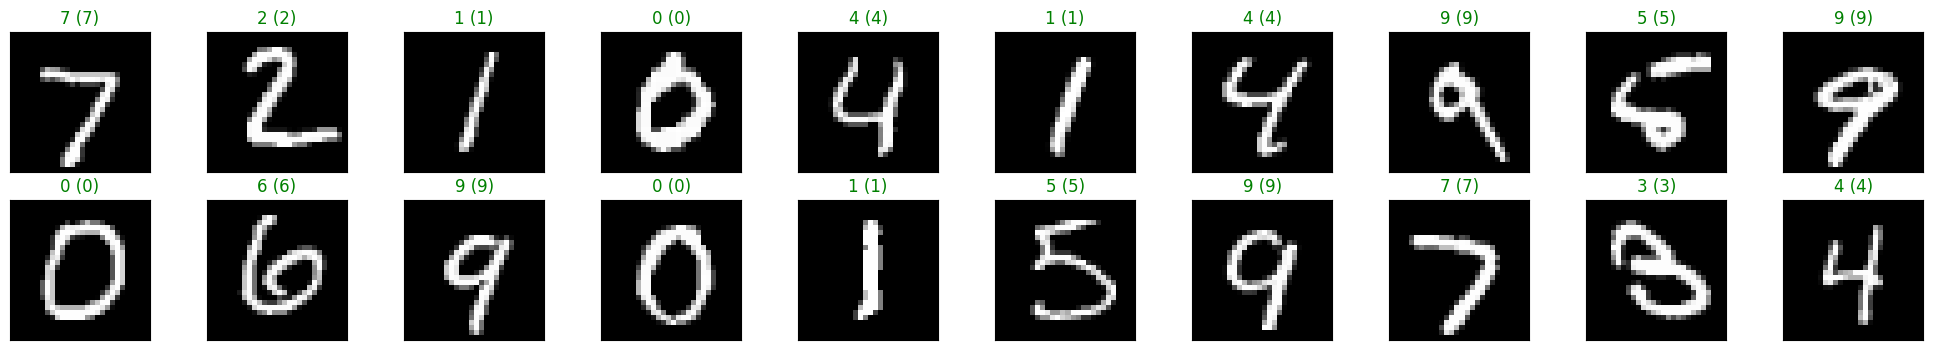

In [48]:
images, labels = iter(test_loader).__next__()
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))